#### Friday, January 19, 2024

Vectorize the Match Images and then store them to Elastic

In [1]:
# Only create the index once ...
createIndex = True

In [2]:
import torch
import os
import torchvision.transforms as transforms
import json
from PIL import Image
from sentence_transformers import SentenceTransformer
from elasticsearch import Elasticsearch, helpers
from tqdm import tqdm

In [3]:

# only target the 4090 ...
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Set the directory containing your images
image_dir = '../../NLP4HTML/express/express-match/public/images'

# set index name
index_name = 'match_images'

Establish the connection to Elastic Search

In [5]:
from elasticsearch import Elasticsearch 

# Password for the 'elastic' user generated by Elasticsearch
# esHost = "https://172.19.0.3:9200"
esHost = "https://172.19.0.2:9200"

ELASTIC_PASSWORD = "*l-ncw4tr*UF-qzEybkq"

path2cert = "/elasticsearch/http_ca.crt"

esClient = Elasticsearch(esHost, ca_certs=path2cert, basic_auth=("elastic", ELASTIC_PASSWORD))

esClient.info()

ObjectApiResponse({'name': 'f8bb06ea76ae', 'cluster_name': 'docker-cluster', 'cluster_uuid': 'JtIKr7BlTaWWORxN6-qEEw', 'version': {'number': '8.11.2', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '76013fa76dcbf144c886990c6290715f5dc2ae20', 'build_date': '2023-12-05T10:03:47.729926671Z', 'build_snapshot': False, 'lucene_version': '9.8.0', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [6]:
# Download and load the image model
model = SentenceTransformer('clip-ViT-B-32-multilingual-v1')

# Prepare the image transformation function
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    lambda image: image.convert("RGB"),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Scan the target images folder, then save the image path names into a pandas dataframe.

In [7]:
import os
import pandas as pd

def scan_images(folder_path):
    image_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp', '.tiff')):
                fullFileName = os.path.join(root, file)
                rootFile = fullFileName.replace(image_dir+"/","")
                userId = rootFile.replace("/"+ file,"")
                image_files.append([fullFileName, rootFile, userId, file])
    return image_files

In [8]:
ImageFiles = scan_images(image_dir)

In [9]:
len(ImageFiles)

17850

In [10]:
someMatchImage = ImageFiles[42]
someMatchImage

['../../NLP4HTML/express/express-match/public/images/47uOeLUWYFpDG9gp2yVOhA2/c8008f65-9dde-eb11-910f-a0369ff9ce34.jpeg',
 '47uOeLUWYFpDG9gp2yVOhA2/c8008f65-9dde-eb11-910f-a0369ff9ce34.jpeg',
 '47uOeLUWYFpDG9gp2yVOhA2',
 'c8008f65-9dde-eb11-910f-a0369ff9ce34.jpeg']

In [16]:
# hot blonde
someMatchImage = 'ko1yxtyDnBYUnshNvpaiAw2/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg'

In [11]:
# Check if the index exists and kill it if it does
if esClient.indices.exists(index=index_name) and createIndex:
    # Delete the index
    esClient.indices.delete(index=index_name)

In [12]:
def create_mapping_if_new(index_name, es):

    # Define the mapping
    mapping = {
      "mappings": {
        "properties": {
          "image_vector": {
            "type": "dense_vector",
            "dims": 512,
            "index": True,
            "similarity": "cosine"
          } ,
          "filename": {
            "type": "keyword"
          }
      }
    }
  }

    # Check if the index does not exist
    if not es.indices.exists(index=index_name):
        # Create the index with the defined mapping
        es.indices.create(index=index_name, body=mapping)

In [13]:
def embed_image(image_path):
    
    # Open the image file
    with Image.open(image_path) as img:
        
        # Apply the transformations to the image
        image = transform(img).unsqueeze(0)

        # If a GPU is available, move the image to the GPU
        if torch.cuda.is_available():
            image = image.to('cuda')
            model.to('cuda')

        # Generate the image vector using the model
        image_vector = model.encode(image)

        # Check if it's a torch tensor and move to CPU if so
        if isinstance(image_vector, torch.Tensor):
            image_vector = image_vector.cpu().numpy()

        # Convert to list
        image_vector = image_vector.tolist()

        # Return the image vector
        return image_vector

In [14]:
def pretty_response(response):
    if len(response['hits']['hits']) == 0:
        print('Your search returned no results.')
    else:
        totalhits = response["hits"]["total"]["value"]
        print(f"Your search returned {totalhits} results.")
        for hit in response["hits"]["hits"]:
            score = hit["_score"]
            id = hit["_id"]
            filename = hit["fields"]["filename"]
            print()
            print(f"ID: {id}")
            print(f"Score: {score}")
            print(f"Filename: {filename}")
    return totalhits


In [17]:
from PIL import Image
imageVector = embed_image(image_dir + "/" + someMatchImage)

In [18]:
type(imageVector)

list

In [19]:
if createIndex:
    # Create new Index with correct mapping if index does not exist
    create_mapping_if_new(index_name, esClient)

In [20]:
if createIndex:
    
    # Initialize a dictionary to hold the image filename and vector
    data = {}

    totalImages = len(ImageFiles)

    # For each image file in the directory
    for i in tqdm(range(totalImages)):

        fullFileName = ImageFiles[i][0]
        fileName = ImageFiles[i][1]
        
        # Get image vector
        image_vector = embed_image(fullFileName)

        # Store it in the data dictionary
        data[fileName] = image_vector[0]

# 5m 30.2s

100%|██████████| 17850/17850 [05:55<00:00, 50.18it/s]


In [21]:
if createIndex:
    # Index the image vectors to Elasticsearch
    documents = []
    for filename, vector in data.items():

        # Create document
        document = {'_index': index_name,
                    '_source': {"filename": filename,
                                "image_vector": vector
                        }
            }


        documents.append(document)

In [22]:
if createIndex:
  
  from elasticsearch.helpers import BulkIndexError

  # Index document
  try:
    helpers.bulk(esClient, documents)
  except BulkIndexError as e:
    for x in e.errors:
      print(x)

# 13.4s 

### kNN Search

Generate a vector for the search image

In [33]:
# this will only come back one time
someMatchImage = '47uOeLUWYFpDG9gp2yVOhA2/c8008f65-9dde-eb11-910f-a0369ff9ce34.jpeg'

In [51]:
# this should come back twice
someMatchImage = 'ko1yxtyDnBYUnshNvpaiAw2/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg'

In [61]:
# This is matched on many other images ...why?
someMatchImage = 'IKOhGb4KOtgKawwzvX6kYA2/b9e03f83-0d71-ed11-90fd-f40343f42de0.jpeg'



In [62]:
from PIL import Image
search_image_vector = embed_image(image_dir + "/" + someMatchImage)

Perform a kNN vector search

In [72]:
knn = {
    "field": "image_vector",
    "query_vector": search_image_vector[0],
    "k": 1, 
    "num_candidates": 10
  }
fields = ["filename"]
size = 1
source = False

results = esClient.search(index=index_name,
                    knn=knn,
                    source=source,
                    fields=fields,
                    size=size
                  )

pretty_response(results)

Your search returned 1 results.

ID: XxG-LY0Br1Wpg8Xo8U2l
Score: 1.0
Filename: ['IKOhGb4KOtgKawwzvX6kYA2/b9e03f83-0d71-ed11-90fd-f40343f42de0.jpeg']


1

How do I loop through every record in the database?

In [ ]:
# Define your query (match_all to retrieve all documents)
query = {"query": {"match_all": {}}}

# Use the scan helper to iterate through all documents
scroll = '2m'  # Set the time for how long the scroll context is kept alive
response = esClient.search(index=index_name, body=query, scroll=scroll, size=10)

SourceMatch = []

# And loop through them
topNo = 10000
recNo = 0

matchNo = 0
maxMatches = 10

while len(response['hits']['hits']) > 0 :

    for hit in response['hits']['hits']:

        score = hit["_score"]
        id = hit["_id"]
        sourceFilename = hit["_source"]["filename"]
        source_image_vector = hit["_source"]["image_vector"]
        print()
        print(f'record No: {recNo}')
        print(f"source ID: {id}")
        print(f"source Score: {score}")
        print(f"source Filename: {sourceFilename}")
        # print(f"source Image Vector: {source_image_vector}")

        recNo += 1


        

        # break

    
    # Use the scroll API to get the next set of results
    response = esClient.scroll(scroll_id=response['_scroll_id'], scroll=scroll)

    # break


# Clear the scroll context when finished
esClient.clear_scroll(scroll_id=response['_scroll_id'])

In [88]:
type(source_image_vector)

list

In [85]:
hit

{'_index': 'match_images',
 '_id': 'jrgLLI0BrmoZcmvzYIj6',
 '_score': 1.0,
 '_source': {'filename': 'zwuhN2JsKCYu_bHIYadOig2/3ceb7bf7-c70f-ee11-9101-f40343f42de0.jpeg',
  'image_vector': [0.18976840376853943,
   0.15049603581428528,
   -0.17023955285549164,
   -0.027072709053754807,
   -0.03721489757299423,
   0.03783026337623596,
   0.0602472648024559,
   -0.17779603600502014,
   0.10879287123680115,
   -0.07035566866397858,
   -0.044170625507831573,
   0.00419020839035511,
   -0.088325634598732,
   0.13176578283309937,
   -0.019909314811229706,
   0.1128029152750969,
   -0.0019908957183361053,
   0.03332186117768288,
   -0.049687378108501434,
   0.008836101740598679,
   0.08571332693099976,
   -0.27568918466567993,
   0.02073279395699501,
   -0.11971578001976013,
   -0.035630375146865845,
   0.05402228608727455,
   -0.12537696957588196,
   0.07784207165241241,
   -0.08317939937114716,
   -0.0767059400677681,
   0.10917574167251587,
   -0.4132910370826721,
   -0.028210565447807312,
  

In [ ]:
# Define your query (match_all to retrieve all documents)
query = {"query": {"match_all": {}}}

# Use the scan helper to iterate through all documents
scroll = '2m'  # Set the time for how long the scroll context is kept alive
response = esClient.search(index=index_name, body=query, scroll=scroll, size=10)

SourceMatch = []

# And loop through them
topNo = 5000
recNo = 0

matchNo = 0
maxMatches = 10

while len(response['hits']['hits']) > 0 :

    for hit in response['hits']['hits']:

        recNo += 1

        score = hit["_score"]
        id = hit["_id"]
        sourceFilename = hit["_source"]["filename"]
        source_image_vector = hit["_source"]["image_vector"]
        print()
        print(f"Record {recNo}")
        print(f"source ID: {id}")
        print(f"source Score: {score}")
        print(f"source Filename: {sourceFilename}")

        # Now find the nearest neighbors
        knn = {
            "field": "image_vector",
            "query_vector": source_image_vector,
            "k": 10,
            "num_candidates": 10
        }
        fields = ["filename"]
        size = 10
        source = False

        # Perform the search
        nearestNeighboors = esClient.search(index=index_name,
                        knn=knn,
                        source=source,
                        fields=fields,
                        size=size
                    )
        
        # And loop through them
        if len(nearestNeighboors['hits']['hits']) == 0:
            print('Your search returned no results.')
        else:
            totalhits = nearestNeighboors["hits"]["total"]["value"]
            #print(f"Your search returned {totalhits} results.")
            for nn in nearestNeighboors["hits"]["hits"]:

                nnScore = nn["_score"]
                id = nn["_id"]
                nnFilename = nn["fields"]["filename"][0]
                print()
                print(f"nn ID: {id}")
                print(f"nn Score: {nnScore}")
                print(f"nn Filename: {nnFilename}")

                if ((nnScore==1.0) and (sourceFilename != nnFilename)):
                    SourceMatch.append([sourceFilename, nnFilename])
                    print(f"Match: {sourceFilename} and {nnFilename}")
                    matchNo += 1

    if recNo >= topNo:
        break

    if matchNo >= maxMatches:
        break

     # Use the scroll API to get the next set of results
    response = esClient.scroll(scroll_id=response['_scroll_id'], scroll=scroll)


# Clear the scroll context when finished
esClient.clear_scroll(scroll_id=response['_scroll_id'])



In [77]:
nn

{'_index': 'match_images',
 '_id': 'FrgLLI0BrmoZcmvzbZsU',
 '_score': 0.9997295,
 'fields': {'filename': ['YQmMDIM7YFW6qxDSpsVX6Q2/14fa17e5-e93a-ee11-9101-f40343f49558.jpeg']}}

In [52]:
match

{'_index': 'match_images',
 '_id': 'w7gLLI0BrmoZcmvzbZsV',
 '_score': 0.99980736,
 'fields': {'filename': ['fFNBj82vkb_dYXHY1zRAMg2/0129bfa4-d6f7-ed11-9106-f40343f4cb58.jpeg']}}

In [36]:
hit

{'_index': 'match_images',
 '_id': 'l7gLLI0BrmoZcmvzYIj6',
 '_score': 1.0,
 '_source': {'filename': 'tELk2_nzXAh2XJa_SNSuTw2/26100f9c-31a2-ed11-90fd-f40343f49558.jpeg',
  'image_vector': [0.16757458448410034,
   0.1913233995437622,
   -0.18251046538352966,
   -0.009919319301843643,
   -0.05562705546617508,
   0.0434904471039772,
   0.05699557065963745,
   -0.08056871592998505,
   0.137684628367424,
   -0.04356241226196289,
   -0.06705070286989212,
   0.0253286175429821,
   -0.11199180781841278,
   0.14474712312221527,
   -0.06082470715045929,
   0.11291345208883286,
   0.024995826184749603,
   0.07551170885562897,
   -0.08028922975063324,
   -0.00882112979888916,
   0.0747143030166626,
   -0.22607460618019104,
   0.0433109775185585,
   -0.07315483689308167,
   -0.03478051722049713,
   0.042394332587718964,
   -0.1322248876094818,
   0.06735377013683319,
   -0.04471398890018463,
   -0.0957847312092781,
   0.08733659982681274,
   -0.41160398721694946,
   -0.04706929996609688,
   -0.04020

In [30]:
results = esClient.search(index=index_name,
                    knn=knn,
                    source=source,
                    fields=fields,
                    size=size
                  )

In [32]:
totalhits = pretty_response(results)

Your search returned 10 results.

ID: FrgLLI0BrmoZcmvzZpJZ
Score: 1.0
Filename: ['SomeMadeUpFolder/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg']

ID: prgLLI0BrmoZcmvzh733
Score: 1.0
Filename: ['ko1yxtyDnBYUnshNvpaiAw2/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg']

ID: brgLLI0BrmoZcmvzY43d
Score: 0.9998051
Filename: ['ngc3jRLiTSvujyHkVL1iYw2/2d9074bc-48b3-eb11-910d-a0369ff9d0f4.jpeg']

ID: argLLI0BrmoZcmvzhrxp
Score: 0.9997879
Filename: ['ACB2xG6b6Cu7pCc3krmqng2/0a2559c8-1911-ee11-9101-f40343f42de0.jpeg']

ID: SLgLLI0BrmoZcmvze661
Score: 0.99976385
Filename: ['riFRSwCOxkkDR2u37AxtyQ2/693450a5-97f2-ed11-9108-f40343f4ab48.jpeg']

ID: YrgLLI0BrmoZcmvzi8EZ
Score: 0.9997597
Filename: ['dpVxBVaQy25SsDuh1KVswA2/d985a1fa-9925-eb11-9109-a0369ff9ce34.jpeg']

ID: gbgLLI0BrmoZcmvzjMOp
Score: 0.9997581
Filename: ['WrnzRObV8oPkTB02M7h5tw2/65c1442a-1b10-ee11-9101-f40343f42de0.jpeg']

ID: -LgLLI0BrmoZcmvzbp15
Score: 0.99974966
Filename: ['fX7GuXj7xXLEdTI-Ti7rYQ2/d249a6f2-1048-ee11-9103-f40343f42de8.jpeg']


In [26]:
duplicates = []
for i in range(totalhits):

    score = results['hits']['hits'][i]['_score']
    fileName = results['hits']['hits'][i]['fields']['filename'][0]

    if score == 1:
        duplicates.append(fileName)

len(duplicates)    

2

In [27]:
result_filename = image_dir + "/" +  results['hits']['hits'][0]['fields']['filename'][0]
result_filename

'../../NLP4HTML/express/express-match/public/images/SomeMadeUpFolder/df2d5f53-5683-ed11-90fd-f40343f49558.jpeg'

Display the top hit

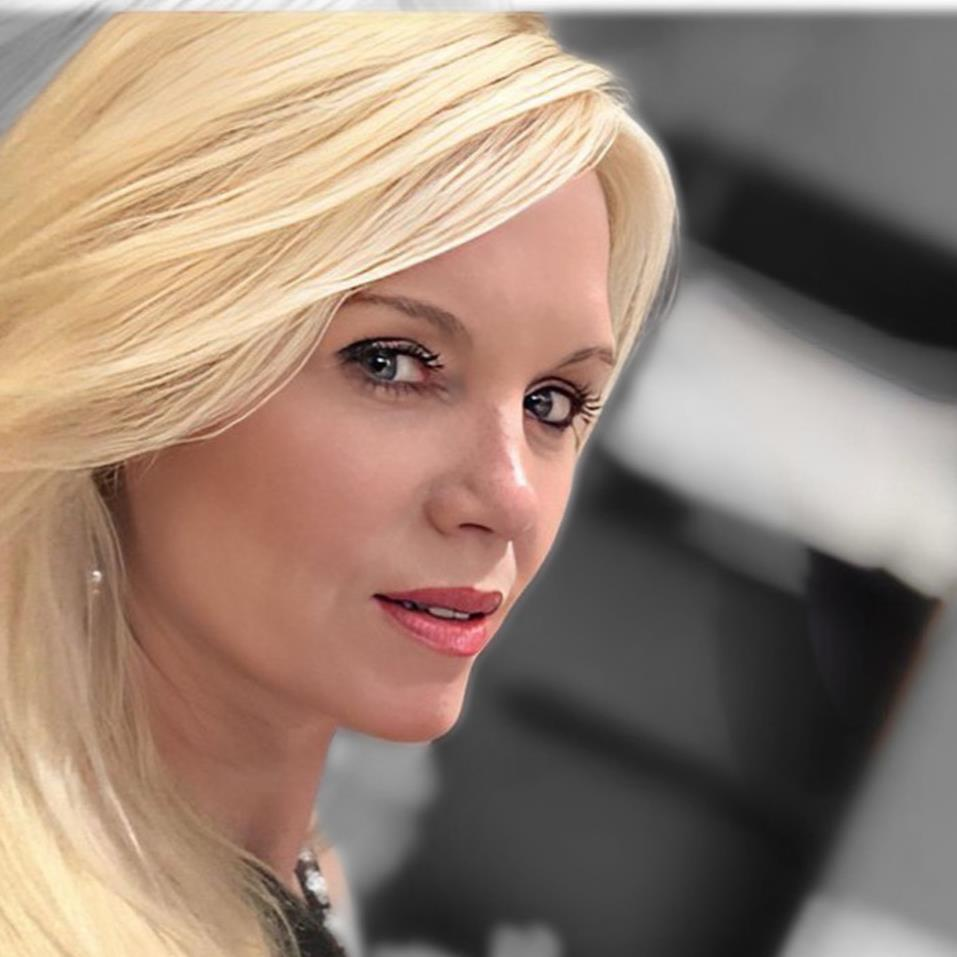

In [28]:
from IPython.display import Image
Image(result_filename, width=400)